In [11]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score
from scipy.stats import mode
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd


class LaplacianMixtureModel:
    def __init__(self, n_components=10, max_iter=30, tol=1e-4, verbose=True):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def _laplace_log_pdf(self, x, mu, b):
        return -np.log(2 * b + 1e-10) - np.abs(x - mu) / (b + 1e-10)

    def _e_step(self, X):
        N, D = X.shape
        log_resp = np.zeros((N, self.K))
        for k in range(self.K):
            log_pdf = np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1)
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

        max_log_resp = np.max(log_resp, axis=1, keepdims=True)
        resp = np.exp(log_resp - max_log_resp)
        resp /= resp.sum(axis=1, keepdims=True)
        return resp

    def _m_step(self, X, resp):
        N, D = X.shape
        Nk = resp.sum(axis=0)
        self.pi = Nk / N

        for k in range(self.K):
            mu_k = np.zeros(D)
            for d in range(D):
                sorted_idx = np.argsort(X[:, d])
                sorted_X = X[sorted_idx, d]
                sorted_weights = resp[sorted_idx, k]
                cum_weights = np.cumsum(sorted_weights)
                median_idx = np.searchsorted(cum_weights, Nk[k] / 2)
                mu_k[d] = sorted_X[median_idx]
            self.mu[k] = mu_k
            self.b[k] = np.sum(resp[:, k][:, None] * np.abs(X - self.mu[k]), axis=0) / Nk[k]
            self.b[k] = np.clip(self.b[k], 1e-3, None)

    def fit(self, X):
        N, D = X.shape
        km = KMeans(n_clusters=self.K, init='k-means++', n_init=10).fit(X)
        self.mu = km.cluster_centers_
        self.b = np.ones((self.K, D))
        self.pi = np.ones(self.K) / self.K
        self.loss_history = []

        progress = trange(self.max_iter, desc="Training LMM", leave=True)
        for i in progress:
            resp = self._e_step(X)
            self._m_step(X, resp)

            if self.verbose:
                log_resp = np.zeros((X.shape[0], self.K))
                for k in range(self.K):
                    log_pdf = np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1)
                    log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf

                max_log = np.max(log_resp, axis=1, keepdims=True)
                log_likelihood = np.sum(max_log + np.log(np.sum(np.exp(log_resp - max_log), axis=1) + 1e-10))

                progress.set_description(f"Iter {i+1} | LogL: {log_likelihood:.2f}")
                self.loss_history.append(log_likelihood)

        self.resp = resp

    def predict(self, X):
        log_resp = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            log_pdf = np.sum(self._laplace_log_pdf(X, self.mu[k], self.b[k]), axis=1)
            log_resp[:, k] = np.log(self.pi[k] + 1e-10) + log_pdf
        return np.argmax(log_resp, axis=1)
    
    def predict_mode(self, X, y_train):
        cluster_assignments = self.predict(X)
        label_map = {}

        for k in range(self.K):
            labels = y_train[cluster_assignments == k]
            if len(labels) > 0:
                label_map[k] = int(mode(labels, keepdims=False).mode)
            else:
                label_map[k] = -1

        mapped_preds = np.array([label_map.get(c, -1) for c in cluster_assignments])
        return mapped_preds

    def predict_soft(self, X, y_train, num_classes=10):
        resp = self._e_step(X)
        label_distribution = np.zeros((self.K, num_classes))
        cluster_assignments = self.predict(X)

        for k in range(self.K):
            labels = y_train[cluster_assignments == k]
            if len(labels) > 0:
                counts = np.bincount(labels, minlength=num_classes)
                label_distribution[k] = counts / counts.sum()

        class_probs = resp @ label_distribution
        return np.argmax(class_probs, axis=1)

    def sample(self, n_samples=10):
        samples = []
        component_ids = np.random.choice(self.K, size=n_samples, p=self.pi)
        for k in component_ids:
            mu_k = self.mu[k]
            b_k = self.b[k]
            u = np.random.uniform(low=-0.5, high=0.5, size=mu_k.shape)
            x = mu_k - b_k * np.sign(u) * np.log(1 - 2 * np.abs(u))
            samples.append(x)
        return np.array(samples), component_ids

    def plot_components(self, pca):
        imgs = pca.inverse_transform(self.mu)
        n_cols = 10
        n_rows = (self.K + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(1 * n_cols, 1 * n_rows))
        axes = axes.flatten()
        for k in range(self.K):
            axes[k].imshow(imgs[k].reshape(28, 28), cmap='gray')
            axes[k].axis('off')
        for k in range(self.K, len(axes)):
            axes[k].axis('off')
        plt.suptitle("LMM Component Means", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

    def plot_loss(self, figsize=(10, 5)):
        plt.figure(figsize=figsize)
        plt.plot(self.loss_history)
        plt.title("Log-Likelihood Loss History")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid()
        plt.show()


In [14]:
def plot_conf_matrix(true, pred, title):
    cm = confusion_matrix(true, pred, labels=np.arange(10))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Load MNIST
mnist = fetch_openml("mnist_784", version=1)
X = mnist.data / 255.0
y = mnist.target.astype(int)

# Subset and PCA
train_samples = 20000
test_samples = 20000

X_train = X[:train_samples]
y_train = y[:train_samples]
X_test = X[train_samples:train_samples + test_samples]
y_test = y[train_samples:train_samples + test_samples]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=50).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Iter 20 | LogL: -18639005326.18: 100%|██████████| 20/20 [03:34<00:00, 10.70s/it]



Test Accuracy with Mode Mapping: 82.06%
Adjusted Rand Index with Mode Mapping: 0.66


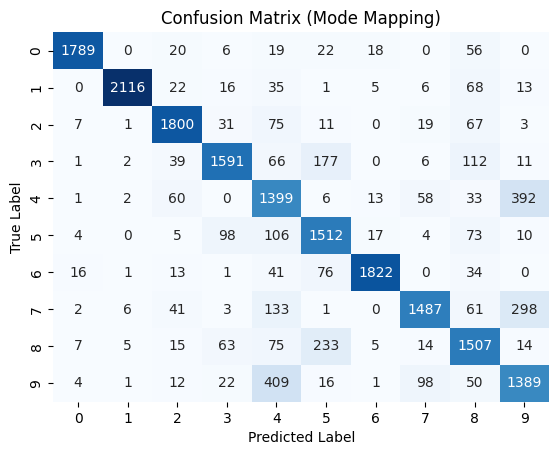

Test Accuracy with Soft Mapping: 83.67%
Adjusted Rand Index with Soft Mapping: 0.69


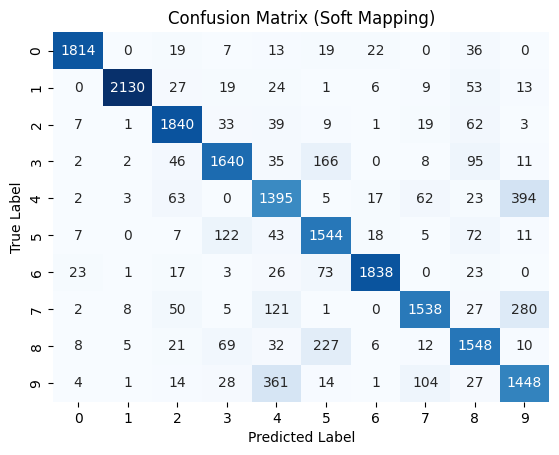

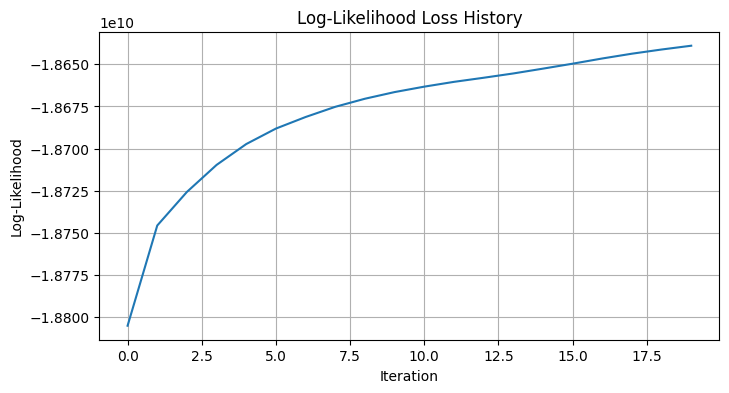

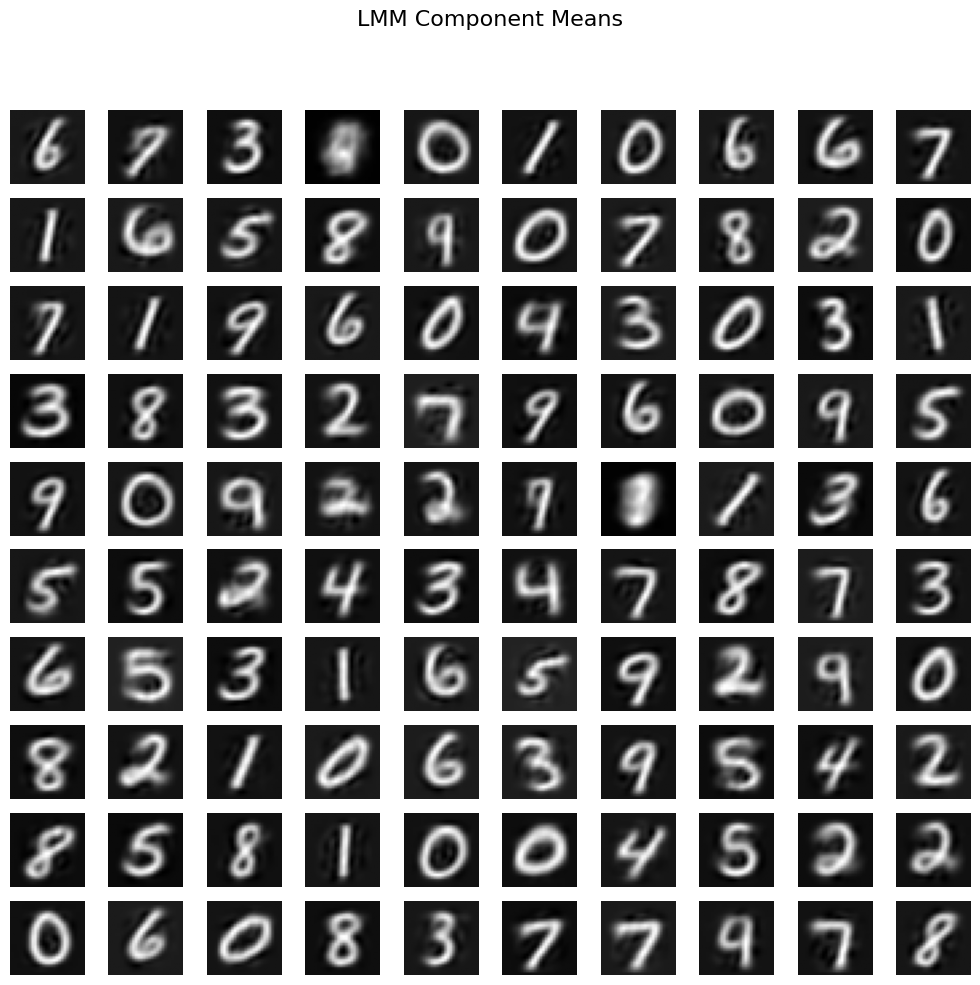

In [22]:
# Initialize and fit the LMM
lmm_full = LaplacianMixtureModel(n_components=100, max_iter=20, verbose=True)
lmm_full.fit(X_train_pca)

# Predict using mode mapping
y_pred_mode = lmm_full.predict_mode(X_train_pca, y_train)
y_test_mode = lmm_full.predict_mode(X_test_pca, y_test)
acc_mode = accuracy_score(y_test, y_test_mode)
ari_mode = adjusted_rand_score(y_test, y_test_mode)
print(f"\nTest Accuracy with Mode Mapping: {acc_mode * 100:.2f}%")
print(f"Adjusted Rand Index with Mode Mapping: {ari_mode:.2f}")

# Confusion matrix for mode mapping
cm_mode = confusion_matrix(y_test, y_test_mode)
sns.heatmap(cm_mode, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix (Mode Mapping)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Predict using soft mapping
y_pred_soft = lmm_full.predict_soft(X_train_pca, y_train)
y_test_soft = lmm_full.predict_soft(X_test_pca, y_test)
acc_soft = accuracy_score(y_test, y_test_soft)
ari_soft = adjusted_rand_score(y_test, y_test_soft)
print(f"Test Accuracy with Soft Mapping: {acc_soft * 100:.2f}%")
print(f"Adjusted Rand Index with Soft Mapping: {ari_soft:.2f}")

# Confusion matrix for soft mapping
cm_soft = confusion_matrix(y_test, y_test_soft)
sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix (Soft Mapping)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


lmm_full.plot_loss(figsize=(8, 4))
lmm_full.plot_components(pca)


Training LMM for digit 0


Iter 50 | LogL: -206448136.85: 100%|██████████| 50/50 [00:02<00:00, 19.25it/s]



Training LMM for digit 1


Iter 50 | LogL: -105704670.73: 100%|██████████| 50/50 [00:03<00:00, 16.07it/s]



Training LMM for digit 2


Iter 50 | LogL: -209806401.58: 100%|██████████| 50/50 [00:02<00:00, 20.42it/s]



Training LMM for digit 3


Iter 50 | LogL: -231085127.27: 100%|██████████| 50/50 [00:02<00:00, 18.52it/s]



Training LMM for digit 4


Iter 50 | LogL: -192354544.58: 100%|██████████| 50/50 [00:02<00:00, 19.96it/s]



Training LMM for digit 5


Iter 50 | LogL: -165696063.67: 100%|██████████| 50/50 [00:02<00:00, 22.77it/s]



Training LMM for digit 6


Iter 50 | LogL: -191284774.81: 100%|██████████| 50/50 [00:02<00:00, 20.42it/s]



Training LMM for digit 7


Iter 50 | LogL: -199545512.67: 100%|██████████| 50/50 [00:02<00:00, 18.57it/s]



Training LMM for digit 8


Iter 50 | LogL: -199992848.89: 100%|██████████| 50/50 [00:02<00:00, 20.67it/s]



Training LMM for digit 9


Iter 50 | LogL: -191393261.39: 100%|██████████| 50/50 [00:02<00:00, 19.25it/s]



Test Accuracy with Classwise LMM (Soft Mapping): 88.18%
Adjusted Rand Index with Classwise LMM (Soft Mapping): 0.76


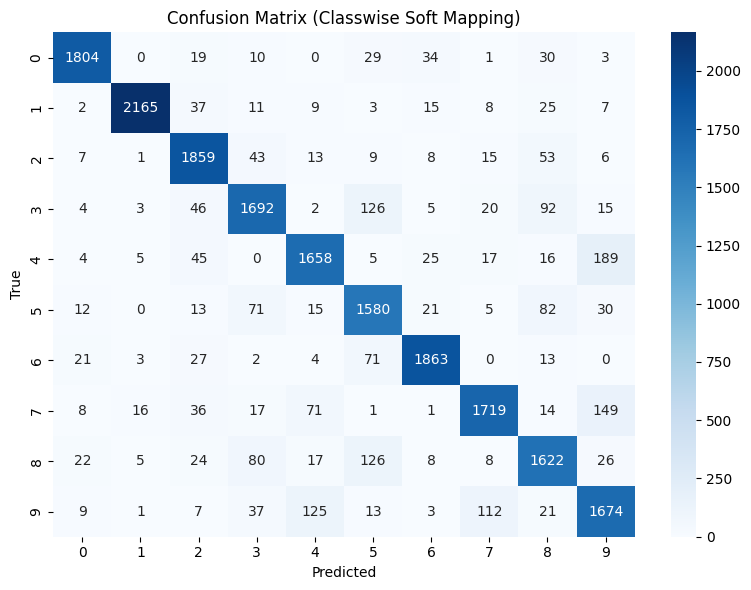

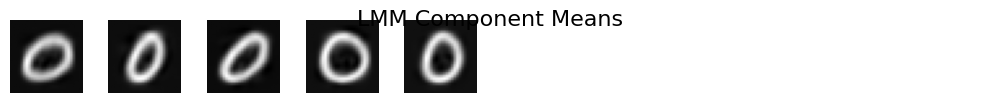

<Figure size 640x480 with 0 Axes>

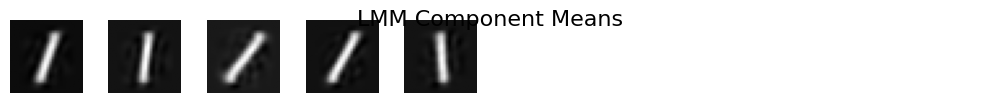

<Figure size 640x480 with 0 Axes>

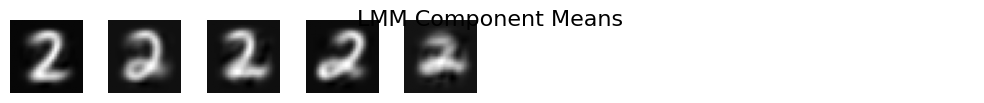

<Figure size 640x480 with 0 Axes>

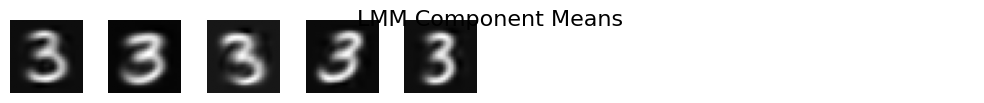

<Figure size 640x480 with 0 Axes>

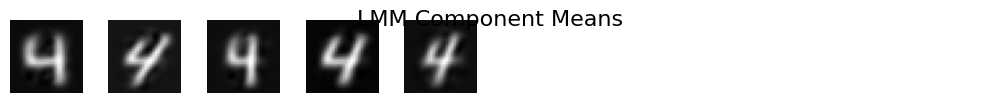

<Figure size 640x480 with 0 Axes>

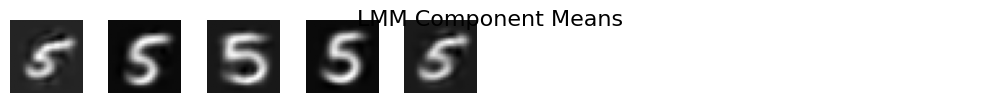

<Figure size 640x480 with 0 Axes>

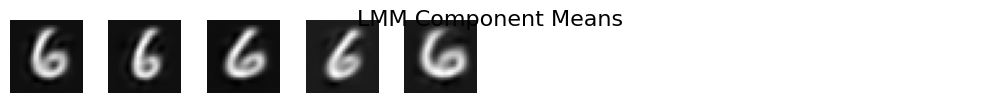

<Figure size 640x480 with 0 Axes>

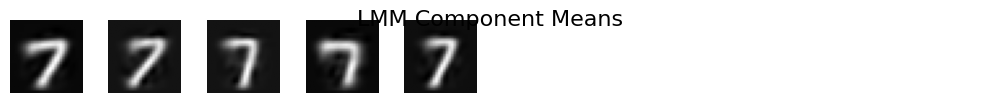

<Figure size 640x480 with 0 Axes>

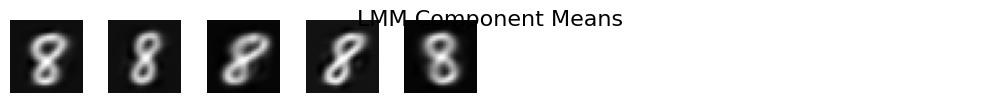

<Figure size 640x480 with 0 Axes>

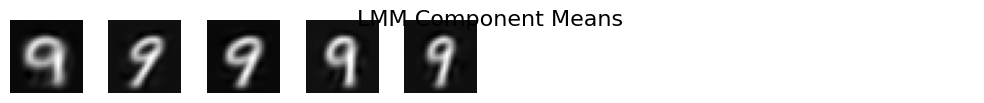

<Figure size 640x480 with 0 Axes>

In [27]:
classwise_lmms = {}

for digit in range(10):
    print(f"\nTraining LMM for digit {digit}")
    X_digit = X_train_pca[y_train == digit]
    lmm = LaplacianMixtureModel(n_components=5, max_iter=50, verbose=True)
    lmm.fit(X_digit)
    classwise_lmms[digit] = lmm

log_likelihoods = np.zeros((X_test_pca.shape[0], 10))

for digit, lmm in classwise_lmms.items():
    log_probs = np.zeros((X_test_pca.shape[0], lmm.K))
    for k in range(lmm.K):
        log_pdf = np.sum(lmm._laplace_log_pdf(X_test_pca, lmm.mu[k], lmm.b[k]), axis=1)
        log_probs[:, k] = np.log(lmm.pi[k] + 1e-10) + log_pdf
    log_likelihoods[:, digit] = np.logaddexp.reduce(log_probs, axis=1)

y_pred_classwise_soft = np.argmax(log_likelihoods, axis=1)
acc_classwise_soft = accuracy_score(y_test, y_pred_classwise_soft)
print(f"\nTest Accuracy with Classwise LMM (Soft Mapping): {acc_classwise_soft * 100:.2f}%")
ari_classwise_soft = adjusted_rand_score(y_test, y_pred_classwise_soft)
print(f"Adjusted Rand Index with Classwise LMM (Soft Mapping): {ari_classwise_soft:.2f}")

# Confusion matrix for classwise soft mapping
plot_conf_matrix(y_test, y_pred_classwise_soft, "Confusion Matrix (Classwise Soft Mapping)")

for digit, lmm in classwise_lmms.items():
    lmm.plot_components(pca)
    plt.suptitle(f"LMM Components for Digit {digit}", fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()    